## Prepare FAPAR from AVHRR Data

In this notebook, 10-daily FAPAR data from the AVHRR Sensors of the NOAA platforms from 1981 - 1999 is processed. The following steps are included:
- Crop data to Germany
- Mask pixels based on quality flags
- Crop to forest area
- Set missing values that are not NA to NA
- Save datasets for needleleaved and broadleaved forests
- Save information on quality flags and counts of high quality pixels per year as csv datasets

In [1]:
# import libraries
import os
import glob
import xarray as xr
import geopandas as gpd
import odc.stac
import rasterio
import pandas as pd
import warnings
import numpy as np

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
# suppress warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# load FAPAR dataset of one day as example
fapar = xr.open_dataset("./Raw/LAI_FAPAR_AVHRR/1981/c3s_FAPAR_19810920000000_GLOBE_AVHRR-NOAA7_V1.0.1.area-subset.55.2.5.45.47.15.2.nc", 
                     decode_coords="all", 
                     decode_times=True)

In [5]:
# look at dataset
fapar

<xarray.Dataset> Size: 1MB
Dimensions:    (lon: 293, time: 1, lat: 246)
Coordinates:
    crs        (lon) |S1 293B ...
  * time       (time) datetime64[ns] 8B 1981-09-20
  * lon        (lon) float64 2kB 5.467 5.5 5.533 5.567 ... 15.1 15.13 15.17 15.2
  * lat        (lat) float64 2kB 55.17 55.13 55.1 55.07 ... 47.07 47.03 47.0
Data variables:
    fAPAR      (time, lat, lon) float32 288kB ...
    fAPAR_ERR  (time, lat, lon) float32 288kB ...
    QFLAG      (time, lat, lon) float32 288kB ...
    NMOD       (time, lat, lon) float32 288kB ...
Attributes: (12/20)
    time_coverage_end:    1981-09-20T23:59:59Z
    time_coverage_start:  1981-08-31T00:00:00Z
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Climate Change Service information 2019
    history:              Processing line : Atmosphetric correction v1.0.6 | ...
    ...                   ...
    references:           https://climate.copernicus.eu/products/
    source:               Derived from EO satellite imagery
    title:                10-daily Fraction of Absorbed Photosynthetically Ac...
    creator_name:         Iskander Benhadj
    creator_email:        iskander.benhadj@vito.be
    date_created:         2019-10-16

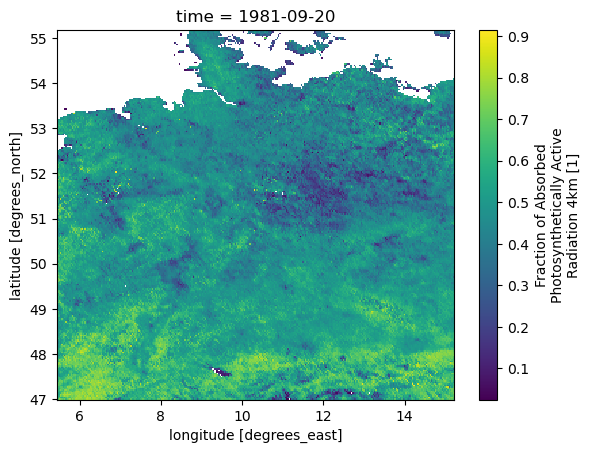

In [6]:
# plot fapar and quality flags to get a first impression
fapar.fAPAR.plot()

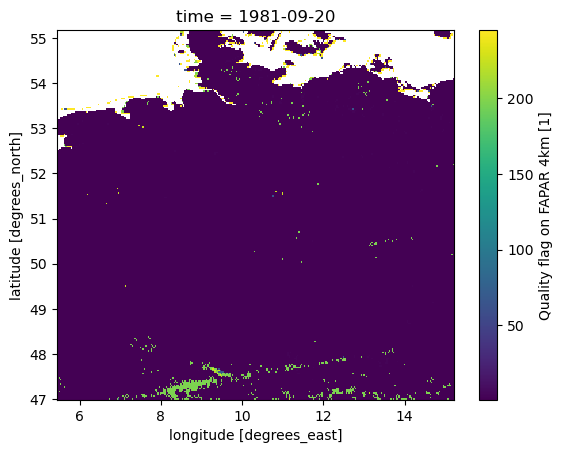

In [7]:
fapar.QFLAG.plot()

In [8]:
# check crs
fapar.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9108"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [9]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

In [10]:
# check if crs matches data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# create mask of research area using the dimensions of the exemplary FAPAR data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                            out_shape=fapar.odc.geobox.shape,
                                            transform=fapar.odc.geobox.affine,
                                            all_touched=False,
                                            invert=False)

In [12]:
ger_mask = xr.DataArray(ger_mask, dims=("lat", "lon"))

In [13]:
# create loop to process all datasets
for year in range(1981, 2000):

    # open 10-daily netCDF datasets of corresponding year
    directory = f"./Raw/LAI_FAPAR_AVHRR/{year}"
    files = glob.glob(os.path.join(directory, "*FAPAR*.nc"))

    for f in range(len(files)):
        file = files[f]

        fapar = xr.open_dataset(file, decode_coords = "all", decode_times = True)

        # apply mask of research area to dataset 
        fapar_ger = fapar.where(~ger_mask)

        # set missing values to NA
        fapar_ger['fAPAR'] = fapar_ger['fAPAR'].where(fapar_ger['fAPAR'] != 65535, np.nan)

        # extract quality flag pixel values as dataframe
        df_qa_pixelvalues = fapar_ger.QFLAG.to_dataframe()

        # count frequency of pixel values and extract to dataframe
        df_qa_freq = df_qa_pixelvalues["QFLAG"].value_counts().to_frame()

        # create new column with quality flag
        df_qa_freq["qa_flag"] = df_qa_freq.index

        # reset index
        df_qa_freq.reset_index(drop = True, inplace = True)

        # rename column with counts
        df_qa_freq.rename({'count':'qa_flag_freq'},axis=1, inplace= True)

        # convert values to integer
        df_qa_freq["qa_flag"] = df_qa_freq["qa_flag"].astype("int16")

        # convert quality flags to binary to assess quality information stored in bits
        df_qa_freq['binary'] = df_qa_freq.qa_flag.apply(lambda x: format(int(x), '08b'))

        # create new columns with the different quality information stored in the bits to assess them seperately
        # source: https://dast.copernicus-climate.eu/documents/satellite-lai-fapar/D3.3.6-v1.1_PUGS_CDR_LAI_FAPAR_AVHRR_v1.0_PRODUCTS_v1.1.pdf 
        df_qa_freq['FAPAR Status'] = df_qa_freq['binary'].astype(str).str[0]
        df_qa_freq['LAI Status'] = df_qa_freq['binary'].astype(str).str[1]
        df_qa_freq['Input Status'] = df_qa_freq['binary'].astype(str).str[2]
        df_qa_freq['BRDF Algorithm Failure'] = df_qa_freq['binary'].astype(str).str[3]
        df_qa_freq['Snow Status'] = df_qa_freq['binary'].astype(str).str[4]
        df_qa_freq['No Data'] = df_qa_freq['binary'].astype(str).str[5]
        df_qa_freq['Land Sea Mask'] = df_qa_freq['binary'].astype(str).str[6:8]

        # extract all quality flag values that are fit for our purpose and should be kept in the dataset
        df_qa_tokeep = df_qa_freq[(df_qa_freq['FAPAR Status']=="0") & 
                                  (df_qa_freq['Input Status']=="0")]
        
        qa_tokeep = df_qa_tokeep["qa_flag"]

        # create a mask for the FAPAR datasets that only keeps pixels of good quality
        mask = fapar_ger["QFLAG"].isin(qa_tokeep).compute()

        # mask dataset
        fapar_masked = fapar_ger["fAPAR"].where(mask, drop = False)

        # load forest area from ESA Landcover data for corresponding year
        # attention: forest data only available for 1992 - 2022 -> choose 1992 for FAPAR data of 1981-1992

        if year <= 1992:
            forest_year = 1992
        else: forest_year = year

        forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                                decode_coords = "all", 
                                decode_times= True)
        
        # drop crs coord as it leads to problems with resampling
        fapar_masked = fapar_masked.drop_vars('crs')

        # set crs for fapar data again
        fapar_masked.rio.write_crs(4326, inplace = True)

        # resample fapar dataset to match resolution of forest dataset
        fapar_match = fapar_masked.rio.reproject_match(forest)

        # rename dimensions - they got renamed while resampling
        fapar_match = fapar_match.rename({'y':'lat', 'x':'lon'})

        # mask fapar with forest data
        # broadleaved forest:
        fapar_BL = fapar_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                        drop = False)

        # needleleaved forest:
        NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
        fapar_NL = fapar_match.where(NL_mask, drop = False)

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        fapar_BL.encoding.update(comp)
        fapar_NL.encoding.update(comp)

        # save as netCDF4 datasets
        date = fapar_match.coords["time"].dt.strftime('%Y-%m-%d').values[0]
        fapar_BL.to_netcdf(f"./FAPAR/10Daily/{year}/FAPAR_{date}_BL.nc")
        fapar_NL.to_netcdf(f"./FAPAR/10Daily/{year}/FAPAR_{date}_NL.nc")

In [14]:
# load one processed dataset as example and plot to get an overview
fapar_NL = xr.open_dataarray("./FAPAR/10Daily/1999/FAPAR_1999-08-10_NL.nc", decode_coords = "all", decode_times= True)
fapar_NL

<xarray.DataArray 'fAPAR' (time: 1, lat: 2952, lon: 3510)> Size: 41MB
[10361520 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 8B 1999-08-10
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
Attributes:
    long_name:      Fraction of Absorbed Photosynthetically Active Radiation 4km
    standard_name:  fraction_of_absorbed_photosynthetically_active_radiation
    units:          1
    valid_range:    [   0 6553]

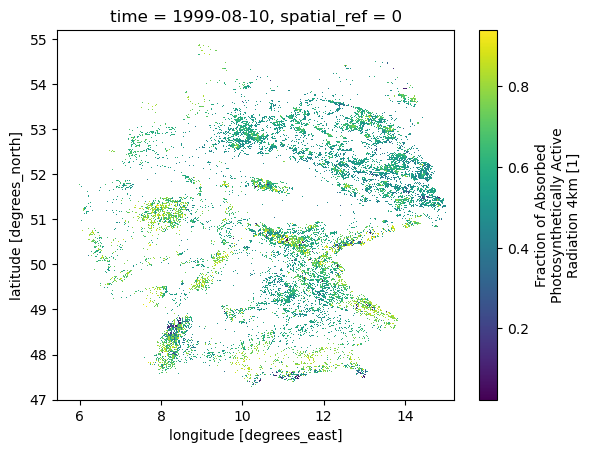

In [15]:
fapar_NL.plot()

In [16]:
# to get more information on pixel quality:
# count quality flag frequencies and pixels of high quality per year
years = []
pixel_counts = []
high_quality_pixel_counts = []

In [17]:
# loop over years to get pixel counts
for year in range(1981, 2000):

    directory = f"./Raw/LAI_FAPAR_AVHRR/{year}"
    filelist = glob.glob(os.path.join(directory, "*FAPAR*.nc"))

    # open netCDF dataset of corresponding year with all 10-daily datasets concatenated
    fapar = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

    # extract quality flag pixel values as dataframe
    df_qa_pixelvalues = fapar.QFLAG.to_dataframe()

    # count frequency of pixel values and extract to dataframe
    df_qa_freq = df_qa_pixelvalues["QFLAG"].value_counts().to_frame()

    # create new column with quality flag
    df_qa_freq["qa_flag"] = df_qa_freq.index

    # reset index
    df_qa_freq.reset_index(drop = True, inplace = True)

    # rename column with counts
    df_qa_freq.rename({'count':'qa_flag_freq'},axis=1, inplace= True)

    # convert values to integer
    df_qa_freq["qa_flag"] = df_qa_freq["qa_flag"].astype("int16")

    # convert quality flags to binary to assess quality information stored in bits
    df_qa_freq['binary'] = df_qa_freq.qa_flag.apply(lambda x: format(int(x), '08b'))

    # create new columns with the different quality information stored in the bits to assess them seperately
    # source: https://dast.copernicus-climate.eu/documents/satellite-lai-fapar/D3.3.6-v1.1_PUGS_CDR_LAI_FAPAR_AVHRR_v1.0_PRODUCTS_v1.1.pdf 
    df_qa_freq['FAPAR Status'] = df_qa_freq['binary'].astype(str).str[0]
    df_qa_freq['LAI Status'] = df_qa_freq['binary'].astype(str).str[1]
    df_qa_freq['Input Status'] = df_qa_freq['binary'].astype(str).str[2]
    df_qa_freq['BRDF Algorithm Failure'] = df_qa_freq['binary'].astype(str).str[3]
    df_qa_freq['Snow Status'] = df_qa_freq['binary'].astype(str).str[4]
    df_qa_freq['No Data'] = df_qa_freq['binary'].astype(str).str[5]
    df_qa_freq['Land Sea Mask'] = df_qa_freq['binary'].astype(str).str[6:8]

    # save quality flag frequencies as csv
    df_qa_freq.to_csv(f"./Tables/FAPAR_Quality_Assessment/FAPAR_QA_Flag_Frequency_{year}.csv")

    # extract all quality flag values that are fit for our purpose and should be kept in the dataset
    df_qa_tokeep = df_qa_freq[(df_qa_freq['FAPAR Status']=="0") & 
                              (df_qa_freq['Input Status']=="0")]
    
    # append counts to lists
    years.append(year)
    pixel_counts.append(sum(df_qa_freq.qa_flag_freq))
    high_quality_pixel_counts.append(sum(df_qa_tokeep.qa_flag_freq))

In [18]:
df_qa_pixel_counts = pd.DataFrame({"Year": years,
                                "Pixels": pixel_counts,
                                "High_Quality_Pixels": high_quality_pixel_counts})

In [19]:
df_qa_pixel_counts

,Year,Pixels,High_Quality_Pixels
0,1981,690965,676404
1,1982,2261340,2185965
2,1983,2261340,2196216
3,1984,2261340,2186891
4,1985,1821635,1725448
5,1986,2261340,2144411
6,1987,2261340,2164840
7,1988,2135710,1953603
8,1989,2261340,2197277
9,1990,2261340,2213819


In [20]:
# save pixel counts as csv
df_qa_pixel_counts.to_csv("./Tables/FAPAR_Quality_Assessment/FAPAR_QA_Pixel_Counts_1981-1999.csv")